In [2]:
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [37]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
#         print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
#         print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
#         print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
#         print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
#         print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]
                    
                    # change to minor allele freq
                    # if maf > 0.5:
                    #     snpdosage = [2.0-s for s in snpdosage]
                    #     ref, alt = alt, ref
                    #     maf = 1 - maf
                    
                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def knn_correction(expr, dosage, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

In [4]:
gencode_file = "/cbscratch/franco/datasets/FHS/probe_annotations.affy"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

In [38]:
# Load real expression
import pandas as pd
df = pd.read_csv("/cbscratch/franco/datasets/FHS/expression/fhs.formatted.expr.one_pedno_rep.txt", header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = [str(x) for x in list(df.index)]
print(gx.shape)
print(np.linalg.matrix_rank(gx))


(17873, 893)
893


In [39]:
# Use real genotype
chrm=12
f_vcf = "/cbscratch/franco/datasets/FHS/genotypes/vcfs/chr{:d}.fhs.vcf.gz".format(chrm)
samplefile = "/cbscratch/franco/datasets/FHS/genotypes/merged_dosages/chr12.fhs.dosages.sample"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 1000, samplefile=samplefile)

import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


GT Sample selection 8453 samples were retained from a total of 8453 samples


In [40]:
gx_norm = normalize_expr( gx[:, exprmask] )
nsample = gx_norm.shape[1]

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)
gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])
gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])

In [41]:
## --- Obtain CisMasks

cismasklist = get_cismasklist(snp_info, genes, chrm, window=1e6)
cismaskcomp = compress_cismasklist(cismasklist)

In [42]:

# ### Optimizes sb2 to a given Keff

# @timeit
# def optimize_sb2(S, sigmasx, target):
#     sbetas = list()
#     S2 = np.square(S)
#     S2_lim = np.percentile(S2, 50)
#     for sx2 in sigmasx:
#         sb2 =  sx2 / S2_lim       # start parameter at median
#         S2mod = S2 + (sx2 / sb2)
#         N = len(S2)
#         Keff = np.sum(S2/S2mod) / N

#         while np.abs(Keff - target) > 0.01:
#             diff = Keff - target
#             sb2 -= diff*(sb2)
#             S2mod = S2 + (sx2 / sb2)
#             Keff = np.sum(S2/S2mod) / N
#         #print("Keff",Keff)
#         #print("SB2=",sb2)
#         sbetas.append(sb2)
#     return np.array(sbetas)

# Y = gx_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K = optimize_sb2(S, sigmax2, 0.5)

# Y = gx_knn_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K_knn = optimize_sb2(S, sigmax2_knn, 0.5)

# # Keffs = []
# # S2 = np.square(S)
# # N = len(S2)
# # for i in range(len(sigmax2_knn)):
# #     S2mod = S2 + (sigmax2_knn[i] / sb2_opt[i])
# #     Keffs.append(np.sum(S2/S2mod) / N)
# # print(Keffs)

In [43]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [44]:
from scipy.optimize import minimize


class SBoptimizer:

    def __init__(self, GT, GX, sx2):

        self._GT  = np.ascontiguousarray(GT)
        self._GX  = np.ascontiguousarray(GX)
        self._sx2 = np.ascontiguousarray(sx2)
        self._nsnps = GT.shape[0]
        self._nsample = GX.shape[1]
        
        U, S, VT = np.linalg.svd(GX.T)
        self._S = S
        self._U = U
        self._S2 = np.square(S)
        self._opt_sb2 = np.zeros(self._nsnps)
    
    @property
    def sb2(self):
        return self._opt_sb2

    def get_ML(self, _sb2, i):
        # sb2 = sb * sb
        sb2 = np.exp(_sb2)
        S2mod = self._S2 + (self._sx2[i] / sb2)
        Rscore = np.sum(np.square(np.dot(self._U.T, self._GT[i,:])) * (self._S2 / S2mod)) / self._sx2[i]
        MLL = -0.5*np.sum(np.log( self._S2 * (sb2 / self._sx2[i]) + 1 )) + 0.5*Rscore

        denom = (self._S2 * sb2 + self._sx2[i])
        der = 0.5* np.sum( ( self._S2 / denom ) * ( (np.square(np.dot(self._U.T, self._GT[i,:])) / denom ) - 1 ) )
        return -MLL, sb2*np.array([-der])

    def fit(self):
        st = time.time()
        
        sb_init = np.exp(0.01)
        for i in range(self._nsnps):
            res = minimize(   self.get_ML,
                              sb_init, 
                              args = i,
                              method='L-BFGS-B',
                              jac = True,
                              #bounds = [[0,1]],
                              options={'maxiter': 200000,
                                       'maxfun': 2000000,
                                       #'ftol': 1e-9,
                                       #'gtol': 1e-9,
                                       'disp': True})

            # print(res)
            self._opt_sb2[i] = np.exp(res.x[0])
        et = time.time()
        print("optimization took in total: ",et-st)

====== Norm - no KNN ======
Found 1 cismasks.
Processing cismask 0: 6 genes masked for 992 snps
====== Norm Shuffled - no KNN ======
Found 1 cismasks.
Processing cismask 0: 6 genes masked for 992 snps
====== Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 6 genes masked for 992 snps
====== Shuffled Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 6 genes masked for 992 snps


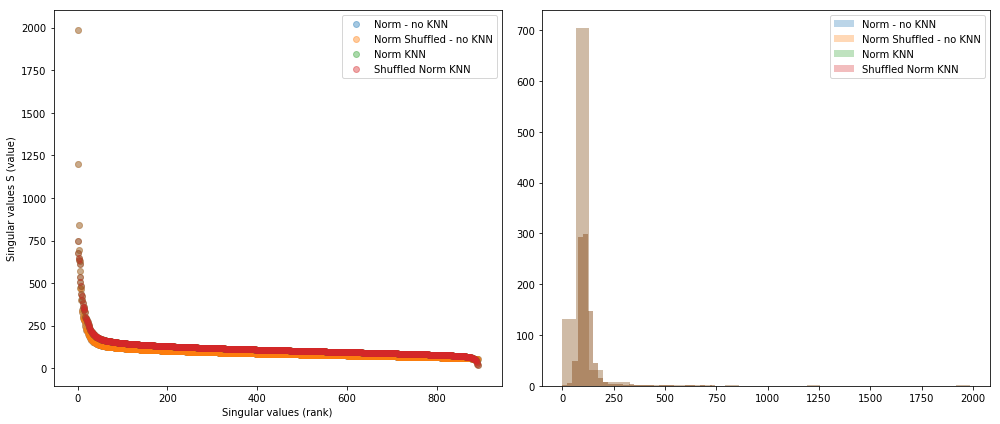

In [45]:
import random

def tejaas_rr(myGT, myGX, sigmax2, sb2):
    nsnps  = myGT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    for j in range(nsnps):       
        S2mod = S2 + (sigmax2[j] / sb2[j])
        Keff[j] = np.sum(S2/S2mod)
        
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
        Rscore[j] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(myGT[j, :].reshape(1, -1), Rscore[j], W)
        
#         rand_gt = copy.deepcopy(myGT[j,:])
#         emp_q = np.zeros(2000)
#         for k in range(2000):
#             random.shuffle(rand_gt)
#             emp_q[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2[j]
#         EmuQ[j]     = np.mean(emp_q)
#         EsigmaQ[j]  = np.var(emp_q)
        
        
    return S2, pvals, Rscore, muQ, sigmaQ, Keff #, EmuQ, EsigmaQ

def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2, sb2 = None, cismasks = None):
        
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
        
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = label, alpha=0.4)
    ax2.hist(S, bins=30, alpha=0.3, label = label)
    
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
            _s2, _pvals, _qscores, _muq, _sigmaq, _keff = tejaas_rr(myGT, myGX, sigmax2[cismask.apply2], sb2)
            pvals[cismask.apply2]  = _pvals
            Rscore[cismask.apply2] = _qscores
            muQ[cismask.apply2]    = _muq
            sigmaQ[cismask.apply2] = _sigmaq
            Keff[cismask.apply2]   = _keff
            
    else:
        S2, pvals, Rscore, muQ, sigmaQ = tejaas_rr(myGT, myGX, sigmax2, sb2)        
    return S2, pvals, Rscore, muQ, sigmaQ, opt_sb2, Keff #, EmuQ, EsigmaQ

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sb2 = np.repeat(0.1*0.1, gt_cent.shape[0])
# sb2 = sb2_opt_K_knn

# - No KNN
nS2, npvals, nQ, nmuQ, nscaledQ, nopt_sb2, nKeff = compare_basic_props(gx_norm, 
                                                                       gt_cent, 
                                                                       ax1, ax2, 
                                                                       'Norm - no KNN', 
                                                                       sigmax2, 
                                                                       sb2 = sb2, 
                                                                       cismasks=cismaskcomp)
shuf_nS2, shuf_npvals, shuf_nQ, shuf_nmuQ, shuf_nscaledQ, shuf_nopt_sb2, shuf_nKeff = compare_basic_props(gx_shuffled_norm, 
                                                                                                          gt_cent, 
                                                                                                          ax1, ax2, 
                                                                                                          'Norm Shuffled - no KNN', 
                                                                                                          sigmax2, 
                                                                                                          sb2 = sb2, 
                                                                                                          cismasks=cismaskcomp)

S2, pvals, Q, muQ, scaledQ, opt_sb2, Keff = compare_basic_props(gx_knn_norm, 
                                                                gt_knn_cent, 
                                                                ax1, ax2, 
                                                                'Norm KNN', 
                                                                sigmax2_knn, 
                                                                sb2 = sb2, 
                                                                cismasks=cismaskcomp)
shuf_S2, shuf_pvals, shuf_Q, shuf_muQ, shuf_scaledQ, shuf_opt_sb2, shuf_Keff = compare_basic_props(gx_shuffled_knn_norm, 
                                                                                                   gt_knn_cent, 
                                                                                                   ax1, ax2, 
                                                                                                   'Shuffled Norm KNN', 
                                                                                                   sigmax2_knn, 
                                                                                                   sb2 = sb2, 
                                                                                                   cismasks=cismaskcomp)

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()

ax2.legend()
plt.tight_layout()
plt.show()


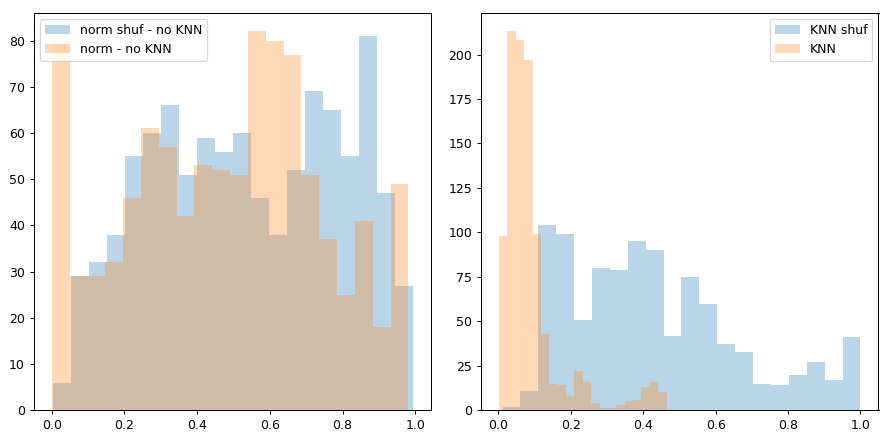

In [46]:
fig = plt.figure(figsize=(10,5), dpi=90)
ax1 = fig.add_subplot(1,2,1)
ax1.hist(shuf_npvals, bins=20, alpha=0.3, label="norm shuf - no KNN")
ax1.hist(npvals, bins=20, alpha=0.3, label="norm - no KNN")
ax1.legend()

# ax1 = fig.add_subplot(1,2,1)
# ax1.scatter(np.log10(shuf_pvals), np.log10(shuf_opt_sb2), s=2, alpha=0.3, label="shuf pvals sb2")
# ax1.scatter(np.log10(pvals), np.log10(opt_sb2), s=2, alpha=0.3, label="pvals sb2")
# ax1.set_ylabel("log10_sb2")
# ax1.set_xlabel("pvalues")
# ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.hist(shuf_pvals, bins=20, alpha=0.3, label="KNN shuf")
ax2.hist(pvals, bins=20, alpha=0.3, label="KNN")
ax2.legend()

plt.tight_layout()
plt.show()


In [36]:
for i in range(100):
    print(snp_info[i].maf, pvals[i], Q[i])

## all in minor allele freq
# maf pval, Q
# 0.3511483762597986 0.08988686835338888 891.5709785228096
# 0.4513281075028001 0.12031239109741021 889.5783079055109
# 0.02006942889137737 0.4415538075052051 892.7416417899757
# 0.020069988801791706 0.44116118273427285 892.7415337036173
# 0.4902513997760345 0.11017749690201017 888.92561772183
# 0.07057838745800671 0.03540377202810918 892.615992307
# 0.46652575587905937 0.10840739900842489 888.5600754258521
# 0.465573908174692 0.11102869447236996 888.5574391122027
# 0.46904311310190355 0.1109061255433168 888.7013442597513

## original
# maf pval Q
# 0.6488516237402019 0.08988686835447424 891.570978522809
# 0.4513281075028001 0.1203123914716887 889.5783079055108
# 0.9799305711086235 0.44155382147487654 892.7416417899753
# 0.9799300111982089 0.44116117570842006 892.7415337036175
# 0.4902513997760345 0.11017749690210543 888.9256177218299
# 0.9294216125419931 0.0354037720284357 892.6159923069999
# 0.46652575587905937 0.10840739900842489 888.5600754258521
# 0.465573908174692 0.11102869401541504 888.5574391122025
# 0.46904311310190355 0.1109061255433168 888.7013442597513

0.3511483762597986 0.08988686835338888 891.5709785228096
0.4513281075028001 0.12031239109741021 889.5783079055109
0.02006942889137737 0.4415538075052051 892.7416417899757
0.020069988801791706 0.44116118273427285 892.7415337036173
0.4902513997760345 0.11017749690201017 888.92561772183
0.07057838745800671 0.03540377202810918 892.615992307
0.46652575587905937 0.10840739900842489 888.5600754258521
0.465573908174692 0.11102869447236996 888.5574391122027
0.46904311310190355 0.1109061255433168 888.7013442597513
0.4806898096304595 0.12855801012173818 888.8175617780776
0.45524748040313556 0.13330980623360178 888.851618566726
0.44891769316909236 0.11847806494053081 888.8310403451281
0.5012385218365067 0.12206084840526443 889.3616237275256
0.46638801791713325 0.10014487313068599 888.6788668674162
0.46752407614781366 0.09961284505352319 888.6986629716408
0.4665369540873461 0.09760941849345595 888.6934644796165
0.468202687569986 0.09573122432006453 888.7272456642983
0.017574468085106355 0.023565237

In [48]:
#old one
for i in range(100):
    print(snp_info[i].maf, pvals[i], Q[i])
    


0.6488516237402019 0.08988686835447424 891.570978522809
0.4513281075028001 0.1203123914716887 889.5783079055108
0.9799305711086235 0.44155382147487654 892.7416417899753
0.9799300111982089 0.44116117570842006 892.7415337036175
0.4902513997760345 0.11017749690210543 888.9256177218299
0.9294216125419931 0.0354037720284357 892.6159923069999
0.46652575587905937 0.10840739900842489 888.5600754258521
0.465573908174692 0.11102869401541504 888.5574391122025
0.46904311310190355 0.1109061255433168 888.7013442597513
0.4806898096304595 0.12855801012163393 888.8175617780777
0.45524748040313556 0.13330980623360178 888.851618566726
0.44891769316909236 0.11847806494043245 888.8310403451281
0.5012385218365067 0.12206084840526443 889.3616237275256
0.46638801791713325 0.10014487313085396 888.678866867416
0.46752407614781366 0.09961284505360735 888.6986629716407
0.4665369540873461 0.09760941849337335 888.6934644796166
0.468202687569986 0.09573122408720058 888.7272456642983
0.9824255319148958 0.023565294342

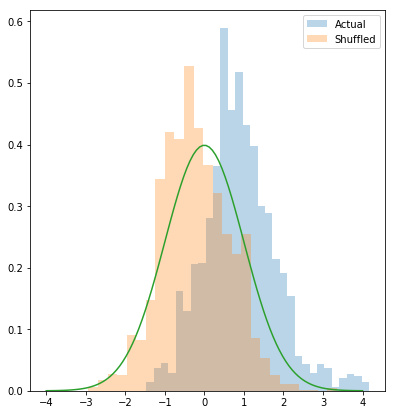

In [20]:
# - no KNN
qscaled = (nQ - nmuQ)/ nscaledQ
shuf_qscaled = (shuf_nQ - shuf_nmuQ)/ shuf_nscaledQ

# - KNN 30
qscaled = (Q - muQ)/ scaledQ
shuf_qscaled = (shuf_Q - shuf_muQ)/ shuf_scaledQ

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.hist(qscaled, bins=30, alpha=0.3, density=True, label="Actual")
ax1.hist(shuf_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")
ax1.legend()

# ax2 = fig.add_subplot(122)
# ax2.hist(qscaled2, bins=30, alpha=0.3, density=True, label="Actual")
# ax2.hist(shuf_qscaled2, bins=30, alpha=0.3, density=True, label="Shuffled")
# ax2.legend()

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')

plt.show()